# Finance meets Data Science

In [1]:
import pandas as pd
import json
import seaborn as sns
import holidays
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") 


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Preprocesamiento de los Datos
Cargar y limpiar los datos: Iniciamos cargando los datos de precios de criptomonedas y limpiándolos

In [24]:
coin_data = pd.read_csv("data/coin_data.csv")
coin_month_data = pd.read_csv("data/coin_month_data.csv")

In [25]:
def extract_from_json(json_str, field):
    try:
        data = pd.json_normalize(json.loads(json_str))
        return data[field][0]
    except (json.JSONDecodeError, KeyError):
        return None

coin_data['market_cap'] = coin_data['json'].apply(lambda x: extract_from_json(x, 'market_data.market_cap.usd'))
coin_data['total_volume'] = coin_data['json'].apply(lambda x: extract_from_json(x, 'market_data.total_volume.usd'))
coin_data.drop('json', axis=1, inplace=True)
coin_data['date'] = pd.to_datetime(coin_data['date']) 
end_date = coin_data['date'].max() 
start_date = end_date - pd.to_timedelta("30 days")
filtered_df = coin_data[(coin_data['date'] >= start_date) & (coin_data['date'] <= end_date)]
coin_data

,coin,date,price,market_cap,total_volume
0,bitcoin,2021-01-01,29022.418395,5.394380e+11,4.350352e+10
1,bitcoin,2021-01-02,29352.126792,5.455933e+11,3.408972e+10
2,bitcoin,2021-01-03,32163.824935,5.978877e+11,5.727344e+10
3,bitcoin,2021-01-04,33008.226203,6.136169e+11,1.788941e+11
4,bitcoin,2021-01-05,31515.575967,5.857263e+11,7.465717e+10
...,...,...,...,...,...
814,cardano,2021-09-26,2.311934,7.420134e+10,5.042846e+09
815,cardano,2021-09-27,2.212884,7.235777e+10,3.307540e+09
816,cardano,2021-09-28,2.138879,6.858612e+10,2.386437e+09
817,cardano,2021-09-29,2.037869,6.555702e+10,2.544152e+09


Cálculo de cambios de precio y niveles de riesgo:
- Calculamos el cambio porcentual diario del precio (price_trend) y la diferencia absoluta (price_diff).
- Definimos el nivel de riesgo de las criptomonedas en función de los cambios de precio en días consecutivos:
1) High Risk: Si hubo una caída del 50% o más en dos días consecutivos.
2) Medium Risk: Si hubo una caída del 20% o más en dos días consecutivos.
3) Low Risk: Para todos los demás casos

In [26]:
coin_data['price_diff'] = coin_data.groupby('coin')['price'].pct_change() * 100

def risk_level(row):
    if row['price_diff'] <= -50:
        return 'High Risk'
    elif row['price_diff'] <= -20:
        return 'Medium Risk'
    else:
        return 'Low Risk'

coin_data['risk_level'] = coin_data.apply(risk_level, axis=1)

Generación de Nuevas Características
- Tendencia y varianza de precios:
- Añadimos la tendencia (price_trend) y la varianza (price_variance) de los precios de los últimos 7 días.

In [27]:
def trend_and_variance(coin_group):
    coin_group['price_trend'] = coin_group['price'].rolling(window=7).apply(lambda x: x[-1] - x[0], raw=True)
    coin_group['price_variance'] = coin_group['price'].rolling(window=7).var()
    return coin_group

df = coin_data.groupby('coin', group_keys=False).apply(trend_and_variance)
df = df.dropna(subset=['price_trend', 'price_variance'])

df

,coin,date,price,market_cap,total_volume,price_diff,risk_level,price_trend,price_variance
6,bitcoin,2021-01-07,36933.520137,6.827437e+11,7.102720e+10,8.365990,Low Risk,7911.101742,7.535607e+06
7,bitcoin,2021-01-08,39547.084081,7.353397e+11,7.864296e+10,7.076401,Low Risk,10194.957289,1.187228e+07
8,bitcoin,2021-01-09,40815.961855,7.589710e+11,8.284647e+10,3.208524,Low Risk,8652.136919,1.364854e+07
9,bitcoin,2021-01-10,40296.529004,7.493472e+11,5.592181e+10,-1.272622,Low Risk,7288.302800,1.422112e+07
10,bitcoin,2021-01-11,38397.895985,7.140790e+11,7.338112e+10,-4.711654,Low Risk,6882.320019,1.191831e+07
...,...,...,...,...,...,...,...,...,...
814,cardano,2021-09-26,2.311934,7.420134e+10,5.042846e+09,1.791169,Low Risk,0.021080,1.803578e-02
815,cardano,2021-09-27,2.212884,7.235777e+10,3.307540e+09,-4.284301,Low Risk,0.131659,1.689274e-02
816,cardano,2021-09-28,2.138879,6.858612e+10,2.386437e+09,-3.344279,Low Risk,0.166698,1.504037e-02
817,cardano,2021-09-29,2.037869,6.555702e+10,2.544152e+09,-4.722542,Low Risk,-0.202459,1.043730e-02


Reestructuración del DataFrame:
- Reestructuramos el DataFrame para incluir los precios de los últimos 7 días como columnas (price_t-1 a price_t-7) y el precio del día siguiente (price_t+1) como la variable objetivo.

In [28]:
for i in range(1, 8):
    df.loc[:, f'price_t-{i}'] = df.groupby('coin')['price'].shift(i)

df.loc[:, 'price_t+1'] = df.groupby('coin')['price'].shift(-1)

df = df.dropna()
df

,coin,date,price,market_cap,total_volume,price_diff,risk_level,price_trend,price_variance,price_t-1,price_t-2,price_t-3,price_t-4,price_t-5,price_t-6,price_t-7,price_t+1
13,bitcoin,2021-01-14,37456.007725,6.966686e+11,6.527894e+10,10.364892,Low Risk,-2091.076356,6.329290e+06,33938.335878,35669.906687,38397.895985,40296.529004,40815.961855,39547.084081,36933.520137,39232.749971
14,bitcoin,2021-01-15,39232.749971,7.297514e+11,5.751944e+10,4.743544,Low Risk,-1583.211883,6.183126e+06,37456.007725,33938.335878,35669.906687,38397.895985,40296.529004,40815.961855,39547.084081,36787.521217
15,bitcoin,2021-01-16,36787.521217,6.843049e+11,6.345074e+10,-6.232621,Low Risk,-3509.007787,4.683199e+06,39232.749971,37456.007725,33938.335878,35669.906687,38397.895985,40296.529004,40815.961855,36254.713079
16,bitcoin,2021-01-17,36254.713079,6.746609e+11,5.505433e+10,-1.448339,Low Risk,-2143.182906,3.110488e+06,36787.521217,39232.749971,37456.007725,33938.335878,35669.906687,38397.895985,40296.529004,35804.263886
17,bitcoin,2021-01-18,35804.263886,6.722919e+11,5.074926e+10,-1.242457,Low Risk,134.357199,2.706963e+06,36254.713079,36787.521217,39232.749971,37456.007725,33938.335878,35669.906687,38397.895985,36595.464769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,cardano,2021-09-25,2.271252,7.400254e+10,5.125188e+09,-2.372131,Low Risk,-0.102125,2.059197e-02,2.326438,2.240328,1.972181,2.081224,2.290854,2.373377,2.348935,2.311934
814,cardano,2021-09-26,2.311934,7.420134e+10,5.042846e+09,1.791169,Low Risk,0.021080,1.803578e-02,2.271252,2.326438,2.240328,1.972181,2.081224,2.290854,2.373377,2.212884
815,cardano,2021-09-27,2.212884,7.235777e+10,3.307540e+09,-4.284301,Low Risk,0.131659,1.689274e-02,2.311934,2.271252,2.326438,2.240328,1.972181,2.081224,2.290854,2.138879
816,cardano,2021-09-28,2.138879,6.858612e+10,2.386437e+09,-3.344279,Low Risk,0.166698,1.504037e-02,2.212884,2.311934,2.271252,2.326438,2.240328,1.972181,2.081224,2.037869


Características temporales:
- Añadimos columnas adicionales para representar características temporales como:

- Día de la semana (day_of_week)
- Si es fin de semana (is_weekend)
- Semana del año (week_of_year)
- Mes (month)

In [29]:
df.loc[:, 'day_of_week'] = df['date'].dt.dayofweek
df.loc[:, 'is_weekend'] = (df['day_of_week'] >= 5).astype(int)  
df.loc[:, 'week_of_year'] = df['date'].dt.isocalendar().week
df.loc[:, 'month'] = df['date'].dt.month 
df

,coin,date,price,market_cap,total_volume,price_diff,risk_level,price_trend,price_variance,price_t-1,...,price_t-3,price_t-4,price_t-5,price_t-6,price_t-7,price_t+1,day_of_week,is_weekend,week_of_year,month
13,bitcoin,2021-01-14,37456.007725,6.966686e+11,6.527894e+10,10.364892,Low Risk,-2091.076356,6.329290e+06,33938.335878,...,38397.895985,40296.529004,40815.961855,39547.084081,36933.520137,39232.749971,3,0,2,1
14,bitcoin,2021-01-15,39232.749971,7.297514e+11,5.751944e+10,4.743544,Low Risk,-1583.211883,6.183126e+06,37456.007725,...,35669.906687,38397.895985,40296.529004,40815.961855,39547.084081,36787.521217,4,0,2,1
15,bitcoin,2021-01-16,36787.521217,6.843049e+11,6.345074e+10,-6.232621,Low Risk,-3509.007787,4.683199e+06,39232.749971,...,33938.335878,35669.906687,38397.895985,40296.529004,40815.961855,36254.713079,5,1,2,1
16,bitcoin,2021-01-17,36254.713079,6.746609e+11,5.505433e+10,-1.448339,Low Risk,-2143.182906,3.110488e+06,36787.521217,...,37456.007725,33938.335878,35669.906687,38397.895985,40296.529004,35804.263886,6,1,2,1
17,bitcoin,2021-01-18,35804.263886,6.722919e+11,5.074926e+10,-1.242457,Low Risk,134.357199,2.706963e+06,36254.713079,...,39232.749971,37456.007725,33938.335878,35669.906687,38397.895985,36595.464769,0,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,cardano,2021-09-25,2.271252,7.400254e+10,5.125188e+09,-2.372131,Low Risk,-0.102125,2.059197e-02,2.326438,...,1.972181,2.081224,2.290854,2.373377,2.348935,2.311934,5,1,38,9
814,cardano,2021-09-26,2.311934,7.420134e+10,5.042846e+09,1.791169,Low Risk,0.021080,1.803578e-02,2.271252,...,2.240328,1.972181,2.081224,2.290854,2.373377,2.212884,6,1,38,9
815,cardano,2021-09-27,2.212884,7.235777e+10,3.307540e+09,-4.284301,Low Risk,0.131659,1.689274e-02,2.311934,...,2.326438,2.240328,1.972181,2.081224,2.290854,2.138879,0,0,39,9
816,cardano,2021-09-28,2.138879,6.858612e+10,2.386437e+09,-3.344279,Low Risk,0.166698,1.504037e-02,2.212884,...,2.271252,2.326438,2.240328,1.972181,2.081224,2.037869,1,0,39,9


Características basadas en volumen transaccionado:
- Calculamos el promedio móvil de 7 días del volumen transaccionado (volume_ma_7) y su varianza (volume_var_7).

In [30]:
df.loc[:, 'volume_ma_7'] = (
    df.groupby('coin')['total_volume'].rolling(window=7).mean().reset_index(level=0, drop=True)
)
df.loc[:, 'volume_var_7'] = (
    df.groupby('coin')['total_volume'].rolling(window=7).var().reset_index(level=0, drop=True)
)

df = df.dropna(subset=['volume_ma_7', 'volume_var_7'])
df

,coin,date,price,market_cap,total_volume,price_diff,risk_level,price_trend,price_variance,price_t-1,...,price_t-5,price_t-6,price_t-7,price_t+1,day_of_week,is_weekend,week_of_year,month,volume_ma_7,volume_var_7
19,bitcoin,2021-01-20,36104.863858,6.717348e+11,5.173699e+10,-1.340606,Low Risk,-1351.143868,1.350824e+06,36595.464769,...,39232.749971,37456.007725,33938.335878,35587.489203,2,0,3,1,5.579411e+10,4.591215e+19
20,bitcoin,2021-01-21,35587.489203,6.624345e+11,5.840662e+10,-1.432978,Low Risk,-3645.260769,1.497554e+06,36104.863858,...,36787.521217,39232.749971,37456.007725,30913.695736,3,0,3,1,5.481234e+10,3.093149e+19
21,bitcoin,2021-01-22,30913.695736,5.752055e+11,6.941531e+10,-13.133249,Low Risk,-5873.825481,4.149740e+06,35587.489203,...,36254.713079,36787.521217,39232.749971,32957.908783,4,0,3,1,5.651175e+10,6.188189e+19
22,bitcoin,2021-01-23,32957.908783,6.132711e+11,6.954974e+10,6.612645,Low Risk,-3296.804297,4.518878e+06,30913.695736,...,35804.263886,36254.713079,36787.521217,32068.087374,5,1,3,1,5.738304e+10,8.130283e+19
23,bitcoin,2021-01-24,32068.087374,5.967444e+11,4.357541e+10,-2.699872,Low Risk,-3736.176511,5.116027e+06,32957.908783,...,36595.464769,35804.263886,36254.713079,32273.517350,6,1,3,1,5.574320e+10,1.090368e+20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,cardano,2021-09-25,2.271252,7.400254e+10,5.125188e+09,-2.372131,Low Risk,-0.102125,2.059197e-02,2.326438,...,2.290854,2.373377,2.348935,2.311934,5,1,38,9,3.809003e+09,2.553589e+18
814,cardano,2021-09-26,2.311934,7.420134e+10,5.042846e+09,1.791169,Low Risk,0.021080,1.803578e-02,2.271252,...,2.081224,2.290854,2.373377,2.212884,6,1,38,9,4.274145e+09,1.873386e+18
815,cardano,2021-09-27,2.212884,7.235777e+10,3.307540e+09,-4.284301,Low Risk,0.131659,1.689274e-02,2.311934,...,1.972181,2.081224,2.290854,2.138879,0,0,39,9,4.476543e+09,1.034554e+18
816,cardano,2021-09-28,2.138879,6.858612e+10,2.386437e+09,-3.344279,Low Risk,0.166698,1.504037e-02,2.212884,...,2.240328,1.972181,2.081224,2.037869,1,0,39,9,4.059733e+09,1.445815e+18


Días festivos en EE.UU. y China:
- Usamos la librería holidays para identificar si cada día es un festivo en EE.UU. o China (is_us_holiday y is_cn_holiday).

In [31]:
us_holidays = holidays.UnitedStates()
cn_holidays = holidays.China()

# Agregar columnas indicando si la fecha es un día festivo en EE.UU. o China
df['is_us_holiday'] = df['date'].apply(lambda x: 1 if x in us_holidays else 0)
df['is_cn_holiday'] = df['date'].apply(lambda x: 1 if x in cn_holidays else 0)

df

,coin,date,price,market_cap,total_volume,price_diff,risk_level,price_trend,price_variance,price_t-1,...,price_t-7,price_t+1,day_of_week,is_weekend,week_of_year,month,volume_ma_7,volume_var_7,is_us_holiday,is_cn_holiday
19,bitcoin,2021-01-20,36104.863858,6.717348e+11,5.173699e+10,-1.340606,Low Risk,-1351.143868,1.350824e+06,36595.464769,...,33938.335878,35587.489203,2,0,3,1,5.579411e+10,4.591215e+19,0,0
20,bitcoin,2021-01-21,35587.489203,6.624345e+11,5.840662e+10,-1.432978,Low Risk,-3645.260769,1.497554e+06,36104.863858,...,37456.007725,30913.695736,3,0,3,1,5.481234e+10,3.093149e+19,0,0
21,bitcoin,2021-01-22,30913.695736,5.752055e+11,6.941531e+10,-13.133249,Low Risk,-5873.825481,4.149740e+06,35587.489203,...,39232.749971,32957.908783,4,0,3,1,5.651175e+10,6.188189e+19,0,0
22,bitcoin,2021-01-23,32957.908783,6.132711e+11,6.954974e+10,6.612645,Low Risk,-3296.804297,4.518878e+06,30913.695736,...,36787.521217,32068.087374,5,1,3,1,5.738304e+10,8.130283e+19,0,0
23,bitcoin,2021-01-24,32068.087374,5.967444e+11,4.357541e+10,-2.699872,Low Risk,-3736.176511,5.116027e+06,32957.908783,...,36254.713079,32273.517350,6,1,3,1,5.574320e+10,1.090368e+20,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,cardano,2021-09-25,2.271252,7.400254e+10,5.125188e+09,-2.372131,Low Risk,-0.102125,2.059197e-02,2.326438,...,2.348935,2.311934,5,1,38,9,3.809003e+09,2.553589e+18,0,0
814,cardano,2021-09-26,2.311934,7.420134e+10,5.042846e+09,1.791169,Low Risk,0.021080,1.803578e-02,2.271252,...,2.373377,2.212884,6,1,38,9,4.274145e+09,1.873386e+18,0,0
815,cardano,2021-09-27,2.212884,7.235777e+10,3.307540e+09,-4.284301,Low Risk,0.131659,1.689274e-02,2.311934,...,2.290854,2.138879,0,0,39,9,4.476543e+09,1.034554e+18,0,0
816,cardano,2021-09-28,2.138879,6.858612e+10,2.386437e+09,-3.344279,Low Risk,0.166698,1.504037e-02,2.212884,...,2.081224,2.037869,1,0,39,9,4.059733e+09,1.445815e+18,0,0


## Predicción con Regresión Lineal


Preparación de los datos de entrenamiento y prueba:
- Seleccionamos las columnas de características y la variable objetivo.
- Dividimos los datos en conjuntos de entrenamiento y prueba.

In [36]:
features = ['price_t-1', 'price_t-2', 'price_t-3', 'price_t-4', 'price_t-5', 'price_t-6', 'price_t-7',
            'day_of_week', 'is_weekend', 'week_of_year', 'month', 'volume_ma_7', 'volume_var_7', 'is_us_holiday', 'is_cn_holiday']
target = 'price_t+1'


X = df[features]
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

Entrenamiento del modelo:
- Entrenamos un modelo de regresión lineal utilizando los datos de entrenamiento.


In [37]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Evaluación del modelo:
- Realizamos predicciones en el conjunto de prueba y evaluamos el modelo calculando el error cuadrático medio (MSE).
- Visualizamos las predicciones en comparación con los valores reales para verificar la precisión del modelo.

In [38]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Error Cuadrático Medio: {mse}')

Error Cuadrático Medio: 6167320.780321851


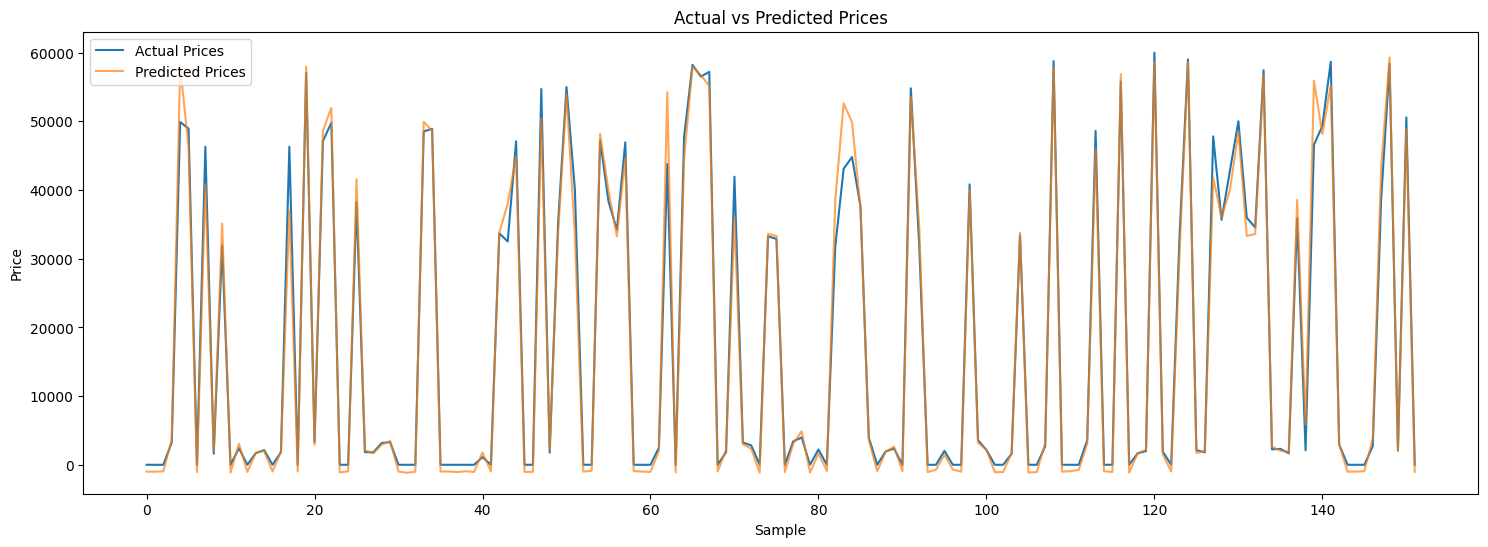

In [39]:
plt.figure(figsize=(18, 6))
plt.plot(y_test.values, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Prices')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.show()

## Plots adicionales
- Plot the prices of bitcoin, ethereum and cardano for the last 30 days

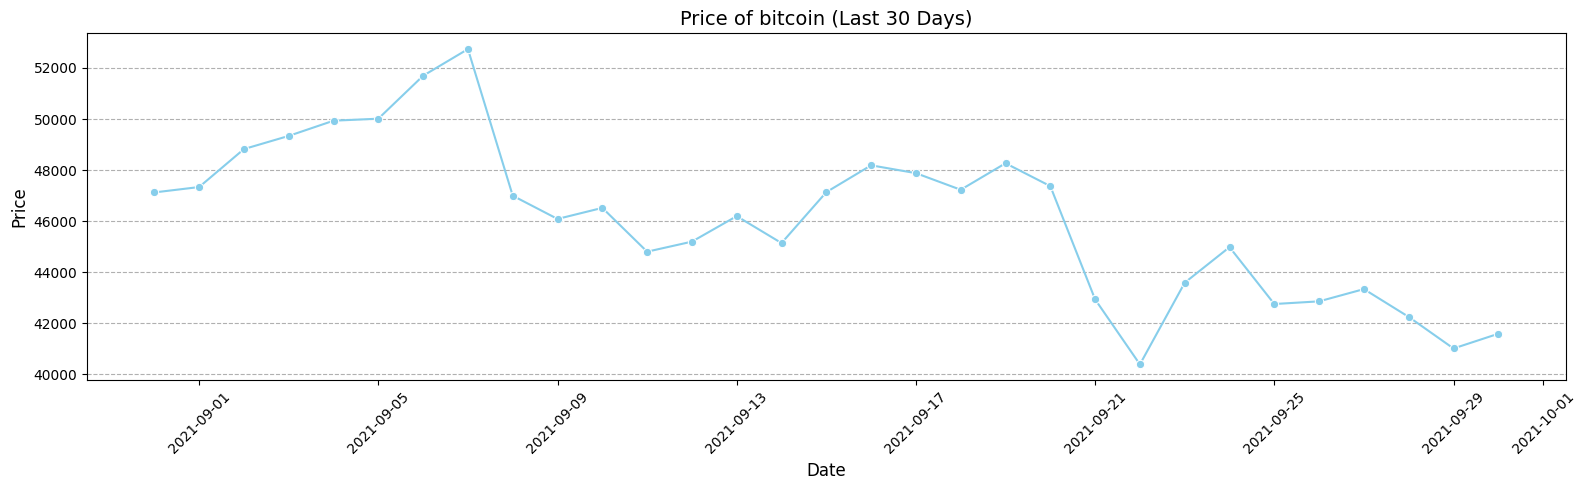

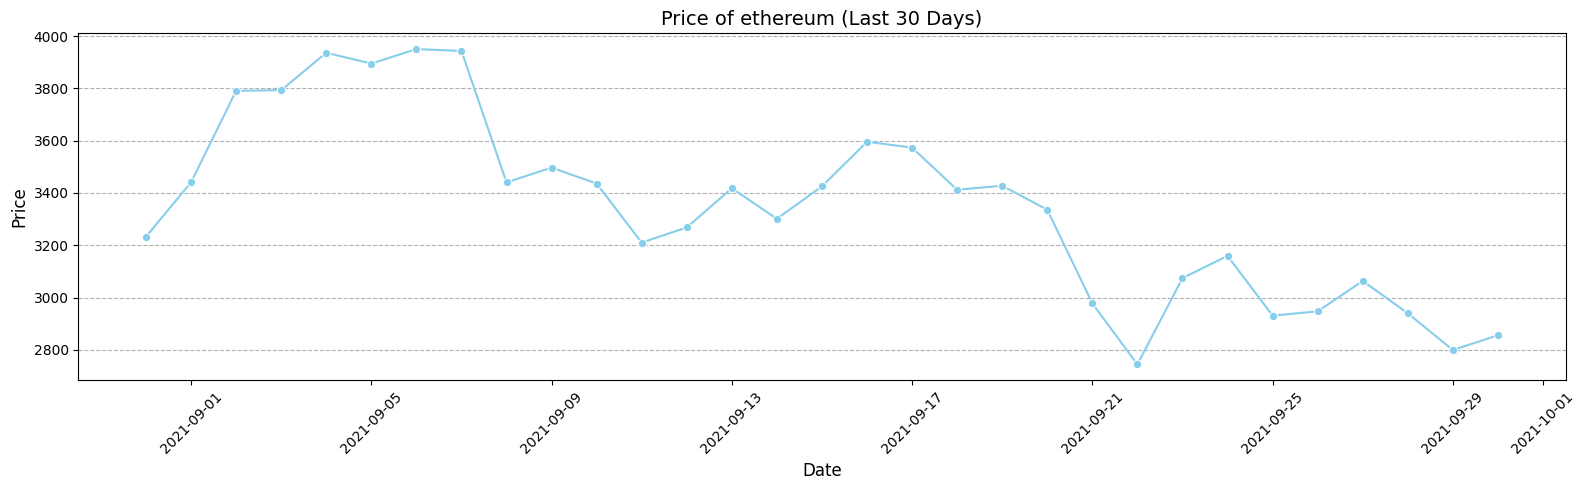

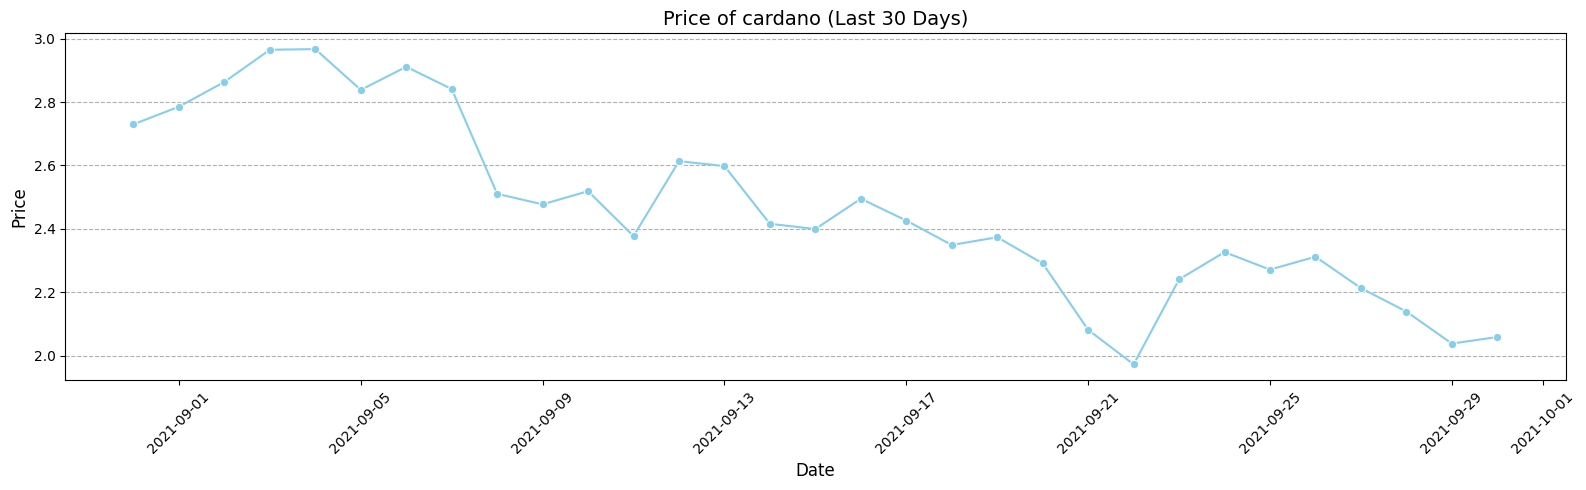

In [21]:
for coin in filtered_df['coin'].unique():
    coin_df = filtered_df[filtered_df['coin'] == coin]

    plt.figure(figsize=(16, 5))  

    sns.lineplot(x='date', y='price', data=coin_df, marker='o', linestyle='-', color='skyblue')

    plt.title(f'Price of {coin} (Last 30 Days)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.grid(axis='y', linestyle='--')
    plt.xticks(rotation=45)


    plt.tight_layout() 
    plt.show()

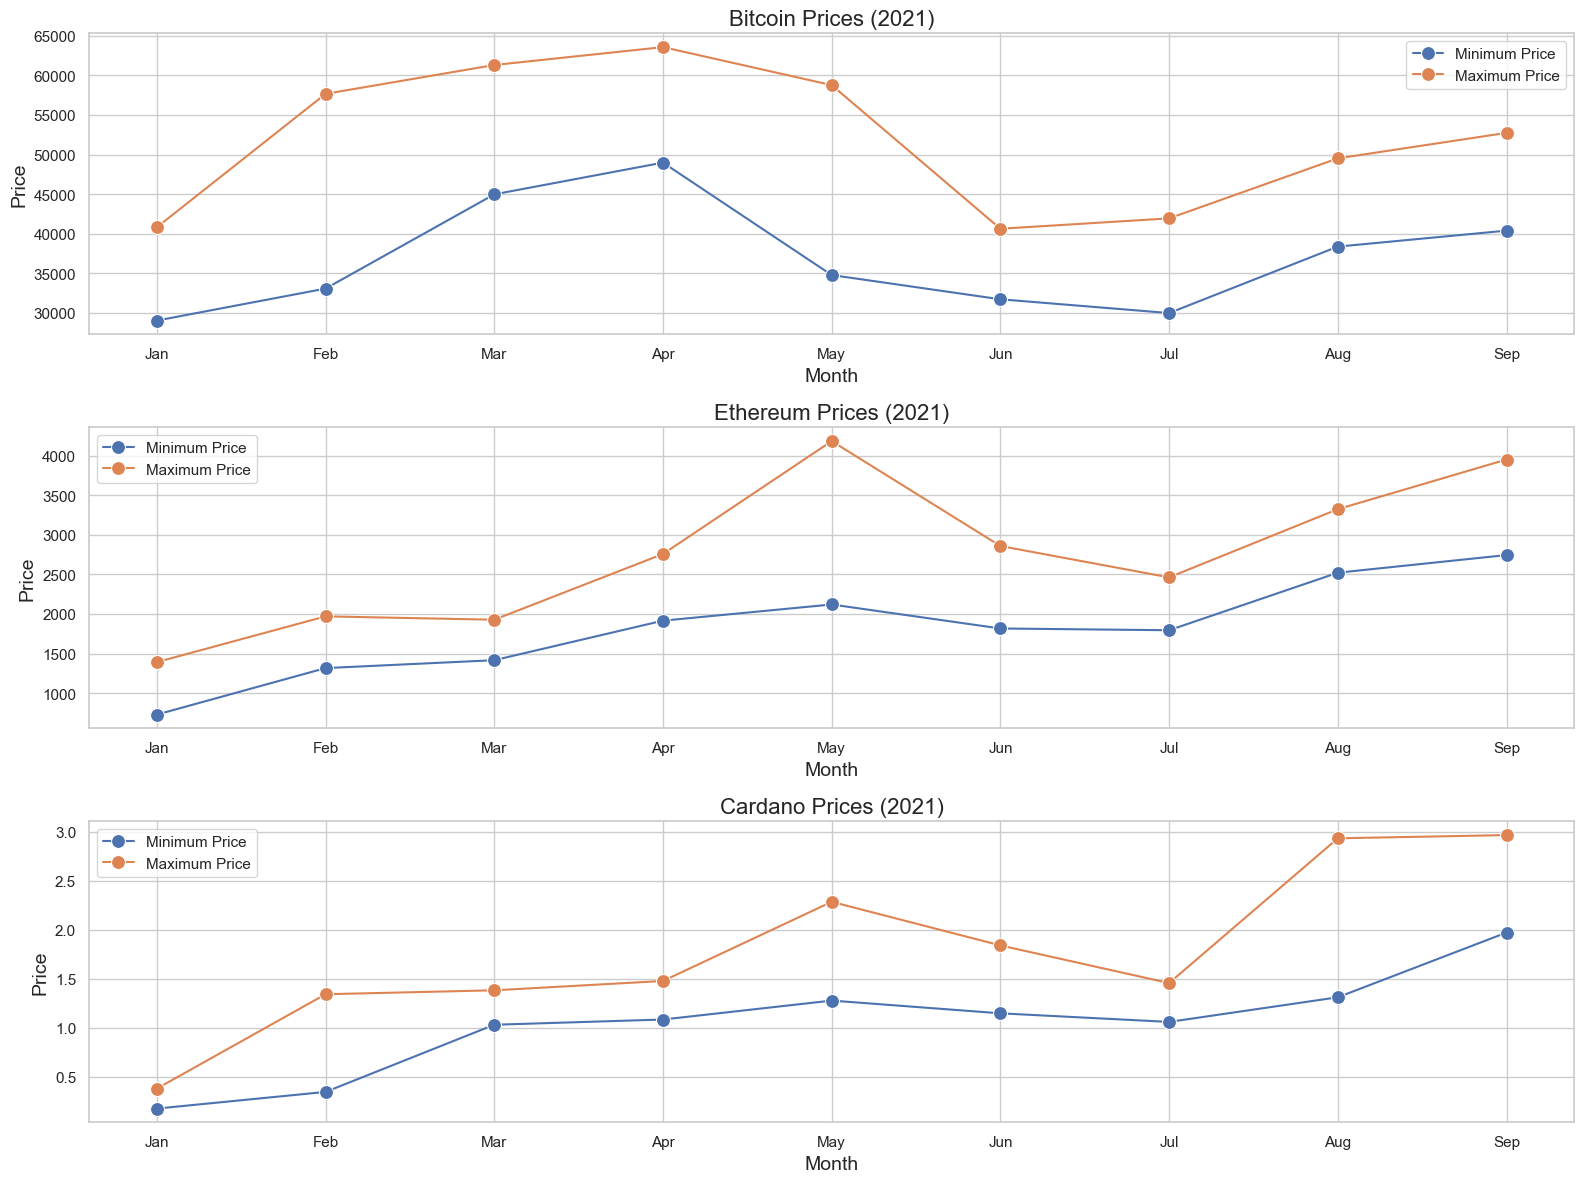

In [46]:
plt.figure(figsize=(16, 12))

# Gráfico para Bitcoin
plt.subplot(3, 1, 1)
sns.lineplot(data=coin_month_data[coin_month_data['coin'] == 'bitcoin'], x='month', y='min_price', marker='o', markersize=10, label='Minimum Price')
sns.lineplot(data=coin_month_data[coin_month_data['coin'] == 'bitcoin'], x='month', y='max_price', marker='o', markersize=10, label='Maximum Price')
plt.title('Bitcoin Prices (2021)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(range(1, 10), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
plt.legend()

# Gráfico para Ethereum
plt.subplot(3, 1, 2)
sns.lineplot(data=coin_month_data[coin_month_data['coin'] == 'ethereum'], x='month', y='min_price', marker='o', markersize=10, label='Minimum Price')
sns.lineplot(data=coin_month_data[coin_month_data['coin'] == 'ethereum'], x='month', y='max_price', marker='o', markersize=10, label='Maximum Price')
plt.title('Ethereum Prices (2021)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(range(1, 10), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
plt.legend()

# Gráfico para Cardano
plt.subplot(3, 1, 3)
sns.lineplot(data=coin_month_data[coin_month_data['coin'] == 'cardano'], x='month', y='min_price', marker='o', markersize=10, label='Minimum Price')
sns.lineplot(data=coin_month_data[coin_month_data['coin'] == 'cardano'], x='month', y='max_price', marker='o', markersize=10, label='Maximum Price')
plt.title('Cardano Prices (2021)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(range(1, 10), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
plt.legend()

# Ajustar espaciado y mostrar el gráfico
plt.tight_layout()
plt.show()

## Conclusión
El proyecto siguió un enfoque sistemático para predecir los precios de criptomonedas utilizando un modelo de regresión lineal. Se realizaron múltiples pasos de preprocesamiento e ingeniería de características para mejorar la calidad de los datos y la precisión del modelo. 
- *Con más tiempo, se podrían implementar prácticas adicionales para mejorar aún más el rendimiento y la robustez del modelo.*

### Prácticas y Adiciones 

- Ingeniería de Características Avanzada
- Validación y Evaluación
- Selección de multiples Modelos
- Optimización de Hiperparámetros
- Normalización/Escalado de Datos
- Visualización y EDA
- Automatización y Pipelines
- Documentación